# RDS HW3 Template

Install the Data Synthesizer library.

# Section

In [ ]:
!pip install DataSynthesizer

In [ ]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']

    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [ ]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']

    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [ ]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)

    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [ ]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# Please follow the steps as instructed when you run the following commands.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas})
downloaded.GetContentFile(real_data_file)
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake})
downloaded.GetContentFile(fake_data_file)
df_fake = pd.read_csv(fake_data_file)

In [ ]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json',
                     'B': './descrption_B.json',
                     'C': './descrption_C.json',
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [ ]:
# Your code here

### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

In [ ]:
# Your code here

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [ ]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

#### KL-divergence for categorical attributes

In [ ]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

In [ ]:
# Use pairwise_attributes_mutual_information function.
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
# Your code here

In [ ]:
# Use can sns.heatmap for pairwise mutual information
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Your code here

## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

In [ ]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
# Your code here

## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

In [ ]:
# Your code here

## Part (d)

Create and inspect differentially privаte spanning tree. There is no need to write your own code for this part, but what you write in the report should demonstrate a nuanced understanding of how the structures differ between the two approaches (DataSynthesizer and MST).

In [ ]:
# Run and then ignore this cell, installing MST
!git clone https://github.com/ryan112358/private-pgm.git
%cd private-pgm
! pip install -r requirements.txt
! python setup.py install
import os, sys
sys.path.append(os.getcwd())
!git clone https://github.com/lurosenb/host_mst_wrapper
sys.path.insert(1, "/content/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer

Cloning into 'private-pgm'...
remote: Enumerating objects: 485, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 485 (delta 131), reused 260 (delta 95), pack-reused 171
Receiving objects: 100% (485/485), 2.14 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (205/205), done.
/content/private-pgm
     |████████████████████████████████| 154 kB 5.3 MB/s 
running install
running bdist_egg
running egg_info
creating src/private_pgm.egg-info
writing src/private_pgm.egg-info/PKG-INFO
writing dependency_links to src/private_pgm.egg-info/dependency_links.txt
writing requirements to src/private_pgm.egg-info/requires.txt
writing top-level names to src/private_pgm.egg-info/top_level.txt
writing manifest file 'src/private_pgm.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'src/private_pgm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
crea

In [ ]:
# Here we have to convert all the data from hw_compas to categorical numerical,
# so that MST can process it.
df_real['sex'] = df_real['sex'].astype('category')
df_real['race'] = df_real['race'].astype('category')
df_real['score'] = df_real['score'].astype('category')
categorical = df_real.select_dtypes(['category']).columns
df_real[categorical] = df_real[categorical].apply(lambda x: x.cat.codes)

Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'age'), ('age', 'score'), ('race', 'score')]


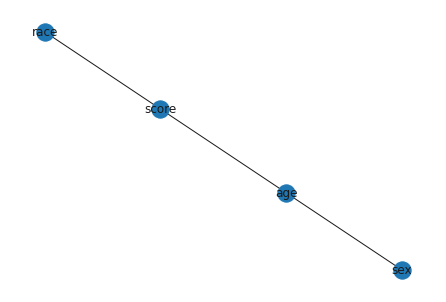

In [ ]:
synth = MSTSynthesizer(epsilon=0.1, domain_path="host_mst_wrapper/mst/compas-domain.json")
synth.fit(df_real)
synth.display_MST_graph()

## Part (e)
### 1. KL Divergence for MST
Study how KL Divergence compares on hw_compas for MST compared to dataset **D** (df_real_D), as you vary __epsilon__ = [0.1, 0.2, ..., 1]. You only need to do this for **5 datasets** per epsilon this time (i.e., run 5 iterations per epsilon). Expect each MST run to take ~15-20 seconds.

You can fit the MST synthesizer using the same code as above for visualizing. Once fit, you can produce a synthetic dataset by simply using the following method:

`mst_fake_data = synth.sample(samples=10000)`

After running this command, `mst_fake_data` will be a pandas dataframe with 10000 rows and with the same columns as whatever dataframe MST was fit on!

In [ ]:
epsilons_mst_kl = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
iters = 5
# Your code here

### 2. Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

In [ ]:
epsilons_mst_mi = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
iters = 5
# Your code here